### Preamble: run this code once

In [ ]:
# to install Latex on Colab (takes ~2 minutes), uncomment:

# !sudo apt install cm-super dvipng texlive-latex-extra texlive-latex-recommended
# plt.rcParams['text.usetex'] = True

The next code snippets include all necessary functions and classes.

In [ ]:
#@title Necessary libraries
from math import sqrt, log10 , floor

import matplotlib.pyplot as plt
import numpy as np
import numpy.random as npr

def significant(x, sig=3):
  return round(x, sig-int(floor(log10(abs(x))))-1) if x else x

In [ ]:
#@title Sampler functions
from scipy.stats import truncnorm, nct

def trunc_norm(mean=0, sd=1, low=0, high=10, size=100):
  """ sampler for truncated normal
      ref: https://stackoverflow.com/questions/18441779 """
  return truncnorm((low-mean)/sd, (high-mean)/sd, loc=mean, scale=sd).rvs(size=size)

def loc_scale_t(df=1, loc=0, scale=1, size=100):
  # var(standard t) is df/(df-2), we need to scale such that var(t) = scale**2
  #scale = sqrt(scale**2 * (df-2)/df)
  return nct(df=df, nc=0, loc=loc, scale=scale).rvs(size=size)

def sampling(population, replace=True, size=100):
  """ sampler over given population with/out replacement """
  return npr.choice(population, size=size, replace=replace)

def delta(x, size=100):
  """ 'sampler' for constant/delta/Dirac distribution """
  return np.full(size, fill_value=x)

def apply(f, *rvs, size=100):
  """ sampler by applying function f to a sequence of random variables """
  return np.vectorize(f)(*[rv.sample(size) for rv in rvs])

# more rng's at https://numpy.org/doc/stable/reference/random/generator.html
def dist(name, *args, **kargs):
  """ sampler for distribution «name» """
  rng = npr.default_rng()
  samplers = {'uniform'     : rng.uniform,           # low, high
              'normal'      : rng.normal,            # loc, scale
              'beta'        : rng.beta,              # a, b
              'binomial'    : rng.binomial,          # n, p
              'gamma'       : rng.gamma,             # shape, scale
              'geometric'   : rng.geometric,         # p
              'exponential' : rng.exponential,       # scale
              'lognormal'   : rng.lognormal,         # mean, sigma
              'neg_bin'     : rng.negative_binomial, # n,p
              'poisson'     : rng.poisson,           # lam
              't'           : loc_scale_t,           # df, loc, scale
              'truncnorm'   : trunc_norm,            # mean, sd, low, upp
              'sampling'    : sampling,              # population, replace
              'δ'           : delta,                 # x
              'apply'       : apply,                 # f, rv1, rv2, ...
             }
  return lambda n: samplers[name](*args, size=n, **kargs)

In [ ]:
#@title Random Variable class
from scipy.stats import entropy, differential_entropy, skew, kurtosis
from collections import namedtuple

Summary = namedtuple('Summary', 'mean low median high skew')

class RV:
  def __init__(self, name, sampler):
    self.name = name
    self.dist = sampler.dist if type(sampler) is RV else sampler

  def sample(self, n=20):
    return self.dist(n)

  def summary(self, n=10_000, alpha=0.95, sig=3):
    xs = self.sample(n)
    return Summary(significant(xs.mean(), sig),
                   significant(np.percentile(xs, 100*(1-alpha)/2), sig),
                   significant(np.median(xs), sig),
                   significant(np.percentile(xs, 100*(1+alpha)/2), sig),
                   significant(skew(xs), sig))

  def E(self, per_sim=100):
    """ returns a random variable of its expected value """
    def dist(n):
      xs = self.sample(n*per_sim).reshape((n, per_sim))
      return np.mean(xs, axis=1)
    return RV(f'E[{repr(self)}]', dist)

  def sd(self, per_sim=100):
    """ returns a random variable of its standard deviation """
    def dist(n):
      xs = self.sample(n*per_sim).reshape((n, per_sim))
      return np.std(xs, axis=1)
    return RV(f'σ({repr(self)})', dist)

  def entropy(self, per_sim=100):
    """ returns a random variable of its entropy (discrete case) """
    def dist(n):
      xs = self.sample(n*per_sim).reshape((n, per_sim))
      # for each row, count occurrences for each unique integer
      n_bins = xs.max()+1
      counts = np.vstack([np.bincount(row, minlength=n_bins) for row in xs])
      # get the probability of each unique value, then compute the entropy
      return entropy(counts/per_sim, axis=1)
    return RV(f'entropy({repr(self)})', dist)

  def diff_entropy(self, per_sim=100):
    """ returns a random variable of its differential entropy (continuous case) """
    def dist(n):
      xs = self.sample(n*per_sim).reshape((n, per_sim))
      return differential_entropy(xs, axis=1)
    return RV(f'entropy({repr(self)})', dist)

  def __add__(self, other):
    if type(other) in [int, float]:  # just shift its mean
      dist = lambda n: self.dist(n) + other
      return RV(f'({self.name}+{other})', dist)
    else:                            # add two distributions
      dist = lambda n: self.dist(n) + other.dist(n)
      return RV(f'({self.name}+{other.name})', dist)

  def __sub__(self, other):
    if type(other) in [int, float]:
      dist = lambda n: self.dist(n) - other
      return RV(f'({self.name}-{other})', dist)
    else:
      dist = lambda n: self.dist(n) - other.dist(n)
      return RV(f'({self.name}-{other.name})', dist)

  def __mul__(self, other):
    if type(other) in [int, float]:
      dist = lambda n: self.dist(n) * other
      return RV(f'({self.name}×{other})', dist)
    else:
      dist = lambda n: self.dist(n) * other.dist(n)
      return RV(f'({self.name}×{other.name})', dist)

  def __rmul__(self, m):
    """ m * dist = dist + dist + ... + dist (m times) """
    def dist(n):
      results = self.dist(n*m).reshape(n,m)
      return np.sum(results, axis=1)
    if type(m) is int:
      return RV(f'({m}×{self.name})', dist)
    else:
      raise NotImplementedError

  def __truediv__(self, other):
    if type(other) in [int, float]:
      dist = lambda n: self.dist(n) / other
      return RV(f'({self.name}÷{other})', dist)
    else:
      dist = lambda n: self.dist(n) / other.dist(n)
      return RV(f'({self.name}÷{other.name})', dist)

  @staticmethod
  def mix(name, dists, weights):
    def dist(n):
      sample = np.concatenate(tuple(np.repeat(d.dist(n), w)
                                    for d,w in zip(dists, weights)))
      return npr.choice(sample, size=n, replace=True)
    return RV(name, dist)

  def __or__(self, other):
    """ mix two distributions 50-50 """
    return RV.mix(f'({self.name}∨{other.name})', [self, other], [1,1])

  def plot(self, n=10_000, ax=None, bins=20, figsize=(5,3),
                 label=True, bar=False, observed_effect=None):
    data = self.dist(n)
    if ax is None:
      fig, ax = plt.subplots(figsize=figsize)
    if label:
      ax.set_title(f'{repr(self)}')
    if bar: # assumes discrete data and uses a bar chart
      xs, counts = sorted(np.unique(data)), np.bincount(data)/len(data)
      if min(xs)>0:
        # work with discrete distributions which support starts at x>0
        counts = counts[min(xs):]
      ax.bar(xs, counts,
             width=0.8, align='center', color='darkblue', edgecolor='white')
      ax.set(xticks=xs)
    else:   # otherwise, the data is continuous and uses an histogram
      weights = np.ones_like(data) / len(data) # sum of all bars is 1
      ax.hist(data, bins=bins, color='darkblue', edgecolor='white', weights=weights);
    if observed_effect:
      ax.axvline(observed_effect, color='r', linestyle='dashed', linewidth=1);

  def __repr__(self):
    return self.name if self.name[0] != '(' else self.name[1:-1]



---



---



# Sampling Statistics

A random variable,

> is a mathematical formalization of a quantity or object which depends on random events. [...] it is a mapping or a function from possible outcomes (e.g., heads and tails after a coin flip) to a measurable space [...] often to the real numbers. [wikipedia](https://en.wikipedia.org/wiki/Random_variable)

For any random variable $X$, it is necessary to state a probabilistic distribution $f$ in order to define the probabilities (or densities) associated to each possible outcome. In notation, we write $X \sim f$.

Several standard [distributions](https://en.wikipedia.org/wiki/List_of_probability_distributions) exist that are useful to model different types of problems.

If $X$ maps to real values, one way to define this relationship is to provide the cumulative distribution function (cdf) of $f$, $F_X$,

$$F_X(x) = \text{Prob}(X \leq x)$$

When available, the respective probability density function (pdf) is also enough -- or a probability mass function (pmf) if the random variable is discrete.

However, given an arbitrary expression, including several random variables, it is not assured that a analytical solution exists for the cdf of the random variable defined by that expression.

This text uses a sampling approach. Instead of providing a distribution by its cdf or pdf, we _provide a sampler of that distribution_.

The main goal herein is to solve a problem by providing samplers that accurately model the problem. These samplers represent a **generative model**, which is a statistical model describing a joint probability for the problem's variables. In other words, the generative model is able to _simulate_ the problem.

When the model is defined, it is executed to generate an arbitrary number of samples/trials in order to compute useful statistics. The typical operation is to count the number of «successes» among the generated samples and report its proportion. But other strategies are possible to solve different types of problems, as we will learn.

The Python code provided in the preamble facilitates the definition of new samplers, so that the users can quickly build and run their own generative models.


> This is similar in essence, but not the same, as resampling methods like bootstrapping or other permutation tests. These methods work with less information, they do not have access to a generative model of the population, they only have access to a sample. But herein, samples are not being reused, they are created anew by the sampler. These two methodologies intersect only when the random variable is associated with a sampling distribution (more details below).

Possible advantages of this approach:

+ Operations over two or more random variables can produce distributions without analytical closed forms. However it is trivial to combine samplers: just sample from all of them, and perform the required operations over the sampled values.

+ Pedagogically, the use of samplers means the teacher can focus on statistical thinking without overburdening the student with mathematical concepts from Calculus.

+ There are no assumptions like in frequentist statistics. All modelling decisions are explicitly made. The quality of the results correlate to how appropriate the generative model is in representing the problem.

And some disadvantages:

+ The process do not compute precise theoretical values, only approximations. However, the results are typically [consistent](https://en.wikipedia.org/wiki/Consistency_(statistics)), so a higher number of samples improves the approximations.

+ This sampler-based approach cannot deal with inferential statistics, i.e., given the observed variables, assign parameter values to the probability distributions of the unobserved variables. However, it is still possible to run common statistical tests, hypothesis testing, and model comparison (check the problems' section for some use cases). For inferential statistics, in a Monte Carlo setting, we need to apply [MCMC](https://en.wikipedia.org/wiki/Markov_chain_Monte_Carlo) methods.

Before moving on, some related books:

+ Simon et al., [Resampling: the new statistics](https://resampling-stats.github.io/resampling-with/python-book/preface_third.html) 3ed (2023 draft)

+ Chihara et al., [Mathematical Statistics with Resampling & R](https://www.amazon.com/dp/1118029852) (2018)

## Using the Tools

Let's check what functions and types are available.

+ Function `dist` returns a sampler for one of the available distributions. A sampler is a function that receives a positive integer $n$ and returns a `numpy` array with $n$ samples from that distribution.

For example, let's create a sampler for a normal distribution with mean $20$ and standard deviaton $3$,

In [ ]:
# check preamble code for all available distributions
a_sampler = dist('normal', loc=20, scale=3)

a_sampler(20)

array([21.82630467, 24.28491511, 18.73438144, 18.54314333, 18.10522448,
       14.19681081, 18.7173154 , 21.62713861, 20.65835183, 22.89483819,
       16.17387027, 23.12214676, 19.59433725, 18.12251883, 20.17619282,
       13.78211842, 15.02082599, 16.95291881, 18.700291  , 18.99522626])

+ Class `RV` defines random variables. It expects a name (a string) and a sampler:

[24.08769579 14.93753866 21.48993127 22.03239106 18.59131043 21.55902939
 21.31065075 16.757073   16.48685534 22.5302771  17.10113278 19.69289521
 16.6021996  14.91318218 20.00396519]
Summary(mean=20.0, low=15.1, median=20.0, high=24.9, skew=-0.0311)


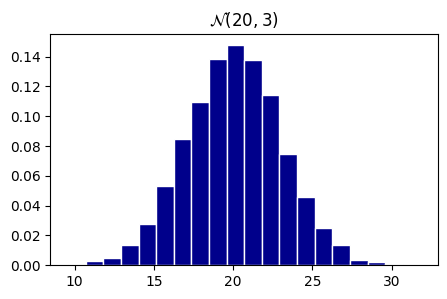

In [ ]:
X = RV(r'$\mathcal{N}(20,3)$', a_sampler)

print(X.sample(15))          # outputs samples
print(X.summary(alpha=0.90)) # summary with some statistics
X.plot()

Class `RV` provides several operations and services.

There are methods that provide the expected value and the standard deviation. Notice that both statistics are defined as expressions of the original random variable, so they too are random variables:

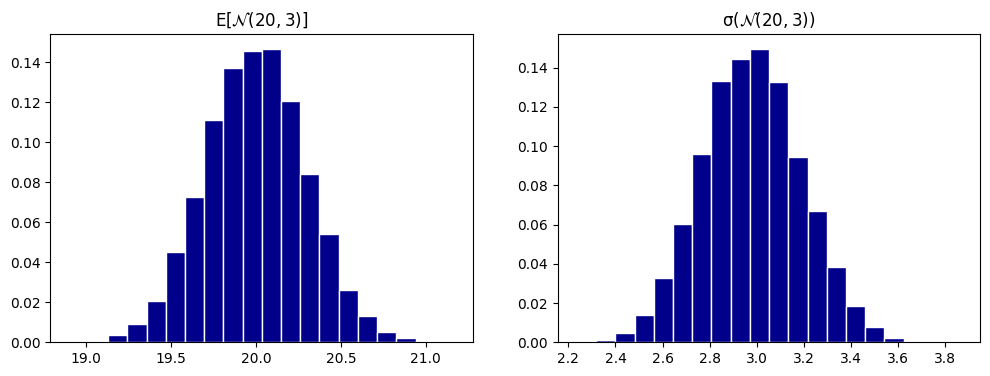

In [ ]:
fig, ax = plt.subplots(figsize=(12,4), ncols=2, nrows=1)
X.E().plot(ax=ax[0])
X.sd().plot(ax=ax[1])

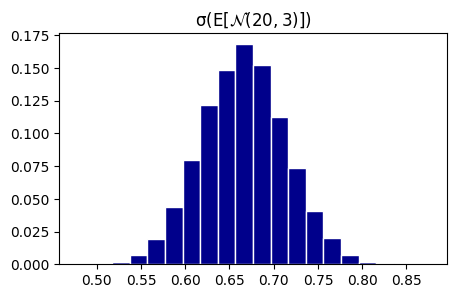

In [ ]:
Y = X.E(per_sim=20).sd()
Y.plot()

If a point estimate is enough, just sample some values and compute its mean or variance,

In [ ]:
(X.sample(100_000).mean(),
 X.sample(100_000).var())

(20.008123734895666, 9.010356665647807)

It's possible to add, subtract, multiply and divide random variables,

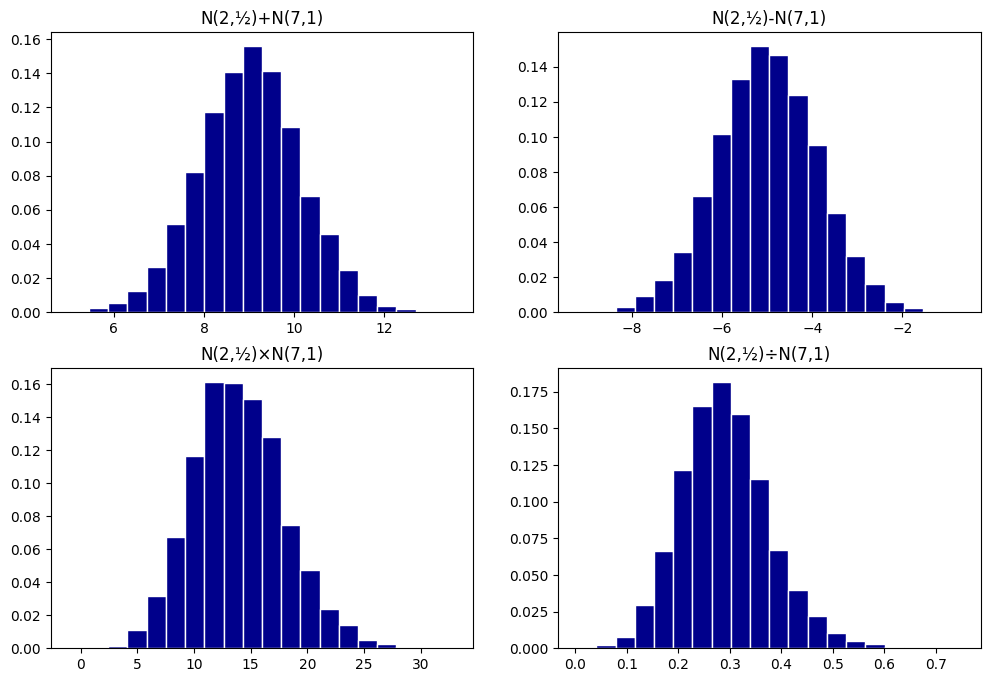

In [ ]:
X = RV(r'N(2,½)', dist('normal', loc=2, scale=0.5))
Y = RV(r'N(7,1)', dist('normal', loc=7, scale=1))

fig, ax = plt.subplots(figsize=(12,8), ncols=2, nrows=2)
(X+Y).plot(ax=ax[0][0])
(X-Y).plot(ax=ax[0][1])
(X*Y).plot(ax=ax[1][0])
(X/Y).plot(ax=ax[1][1])

Multiplication by a number has different meanings if the number is at the left or at the right,

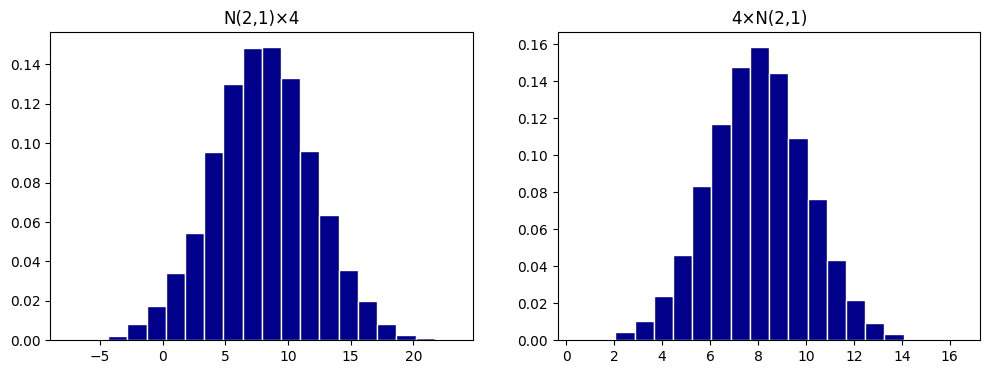

In [ ]:
X = RV(r'N(2,1)', dist('normal', loc=2, scale=1))
Y = X*4  # multiplies each sample value by 4
Z = 4*X  # each sample is the sum of four samples from X

fig, ax = plt.subplots(figsize=(12,4), ncols=2, nrows=1)
Y.plot(ax=ax[0])
Z.plot(ax=ax[1])

To obtain a random variable which is the mean of $n$ iid random variables $X_i$, use method `E` with parameter `per_sim=n`,

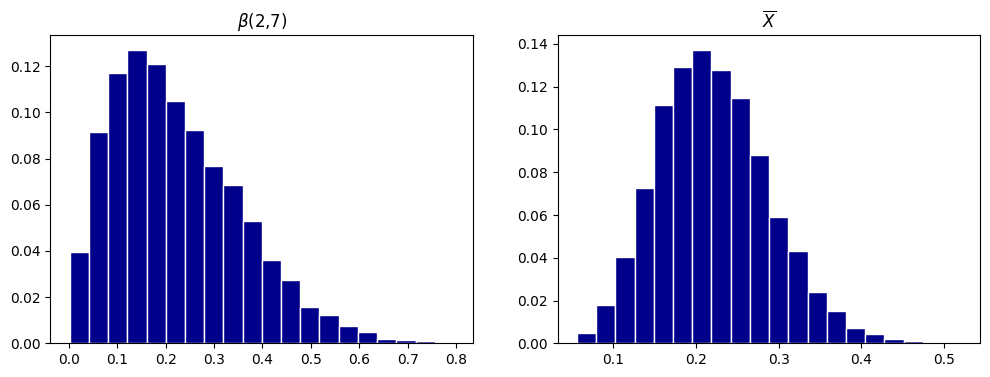

In [ ]:
X = RV(r'$\beta$(2,7)', dist('beta', a=2, b=7))
Y = X.E(per_sim=4) # Y is the mean of four X_i
Y.name = r'$\overline{X}$'

fig, ax = plt.subplots(figsize=(12,4), ncols=2, nrows=1)
X.plot(ax=ax[0])
Y.plot(ax=ax[1])

Class `RV` includes operator `|` to mix two random variables:

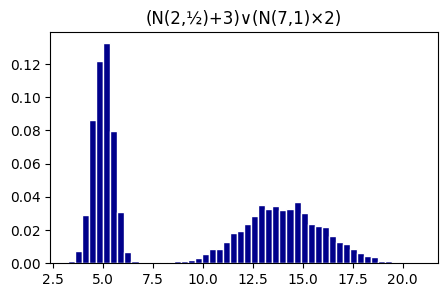

In [ ]:
X = RV(r'N(2,½)', dist('normal', loc=2, scale=0.5))
Y = RV(r'N(7,1)', dist('normal', loc=7, scale=1))

Z = (X+3)|(Y*2)
Z.plot(bins=50)

The user builds her generative models by defining samplers (with function `dist`), and random variables (with class `RV`). Nothing else is needed!

## Checking Some Statistical Equalities

Given a distribution $X$ with finite expected value and variance,

In [ ]:
X = RV('N', dist('normal', 0, 1))
n = 100_000  # sample size

Let's check some equalities via sampling:

+ $\text{E}[aX+b] = a \text{E}[X]+b$

In [ ]:
a, b = 2, 3
Y = X*a + b

Ex, Ey = X.sample(n).mean(), Y.sample(n).mean()
print(f'{a*Ex+b:.3f} ≈ {Ey:.3f}')

3.003 ≈ 3.002


+ $\text{Var}(X_1 + \cdots + X_m) = m \text{Var}(X)$

In [ ]:
m = 3
Y = m*X

varX, varY = X.sample(n).var(), Y.sample(n).var()
print(f'{m*varX:.3f} ≈ {varY:.3f}')

2.992 ≈ 3.002


+ $\text{Var}(aX+b) = a^2 \text{Var}(X)$

In [ ]:
a, b = 4, 6
Y = X*a+b

varX, varY = X.sample(n).var(), Y.sample(n).var()
print(f'{a*a*varX:.3f} ≈ {varY:.3f}')

15.993 ≈ 16.023


+ $\text{Var}(X-Y) = \text{Var}(X) + \text{Var}(Y)$

In [ ]:
X = RV('N', dist('normal', 3, 1))
Y = RV('N', dist('normal', 2, 2))
Z = X-Y

varX, varY, varZ = X.sample(n).var(), Y.sample(n).var(), Z.sample(n).var()
print(f'{varX+varY:.3f} ≈ {varZ:.3f}')

4.995 ≈ 4.970


+ $\text{Var}\big(\frac{X_1 + \cdots + X_m}{m}\big) = \frac{\text{Var}(X)}{m}$

In [ ]:
m = 10
X = RV('N', dist('normal', 0, 1))
X_mean = X.E(per_sim=m)

varX, varEx = X.sample(n).var(), X_mean.sample(n).var()
print(f'{varX/m:.3f} ≈ {varEx:.3f}')

0.100 ≈ 0.100


## δ distribution

We can model a fair coin by defining a random generator of zeros and ones with equal probability:

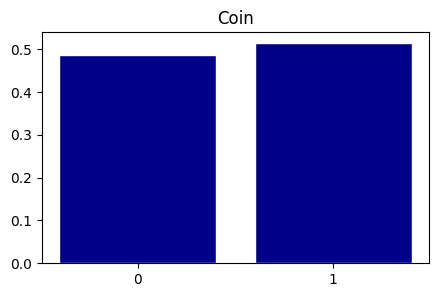

In [ ]:
fair_flips_sampler = lambda n: 0+(npr.random(size=n) < 0.5)

Coin_v0 = RV('Coin', fair_flips_sampler)
Coin_v0.plot(bar=True)

Another way is to define _Head_ and _Tail_ as two constant distributions (modelled by delta distributions). Then the coin is the equal mix of these two:

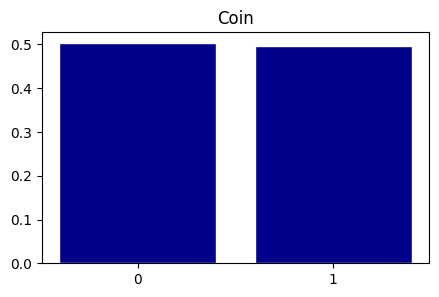

In [ ]:
Head = RV('Head', dist('δ', 0))
Tail = RV('Tail', dist('δ', 1))
Coin = RV('Coin', Head|Tail) # uses sampler of given random variable

Coin.plot(bar=True)

Or simply:

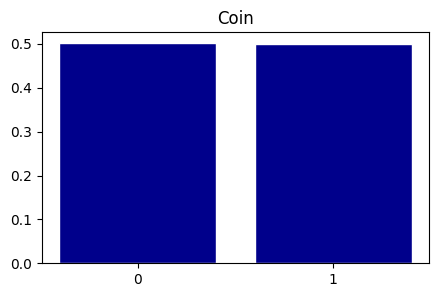

In [ ]:
Coin = Head | Tail
Coin.name = 'Coin'

Coin.plot(bar=True)

## Sampling Distributions

A sampling distribution is a probability distribution of a statistic obtained through repeated sampling of a specific population.

A dice can be seen has a sampling distribution for numbers $1$ to $6$.

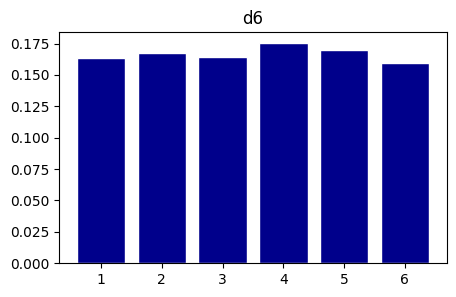

In [ ]:
dice6 = RV('d6', dist('sampling', population=[1,2,3,4,5,6], replace=True))
dice6.plot(bar=True)

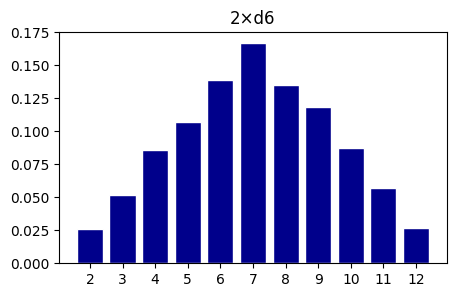

In [ ]:
(2*dice6).plot(bar=True)

The next example defines a random variable that samples permutations of the initial list:

In [ ]:
permute = RV('perm', dist('sampling', population=[1,2,3,4,5,6], replace=False))

for _ in range(10):
  print(permute.sample(6))

[4 2 3 6 5 1]
[5 4 1 6 3 2]
[6 4 2 1 5 3]
[6 2 3 5 1 4]
[2 6 1 4 5 3]
[1 4 5 6 3 2]
[5 6 3 4 1 2]
[1 2 4 6 5 3]
[1 4 6 3 2 5]
[6 4 5 3 2 1]


We can use `permute` to create a new sampler, which defines a random variable that samples entire permutations of the initial list:

In [ ]:
sampler = lambda n: np.array([permute.sample(6) for _ in range(n)])
P = RV('perm', sampler)

P.sample(10)

array([[3, 6, 4, 2, 5, 1],
       [6, 2, 4, 5, 1, 3],
       [2, 6, 5, 4, 3, 1],
       [5, 4, 3, 6, 1, 2],
       [5, 6, 1, 4, 2, 3],
       [2, 4, 1, 5, 3, 6],
       [4, 3, 5, 1, 2, 6],
       [5, 6, 3, 1, 2, 4],
       [5, 4, 1, 6, 2, 3],
       [4, 1, 5, 2, 3, 6]])

The population can be any numerical list,

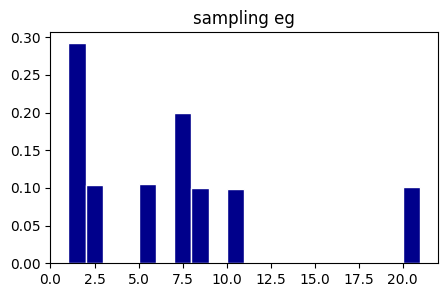

In [ ]:
S = RV('sampling eg', dist('sampling', population=[1,1,1,2,5,7,7,8,10,21]))
S.plot()

Let's show the Central Limit Theorem in action:

In [ ]:
from ipywidgets import interact, widgets

def show(n):
  S.E(per_sim=n).plot()
  plt.show() # this prevents duplicate plots in Colab

interact(lambda n: show(n), n=widgets.IntSlider(min=1, max=50, value=1));

interactive(children=(IntSlider(value=1, description='n', max=50, min=1), Output()), _dom_classes=('widget-int…

### Bootstrap

This sampling distribution allow us to perform resampling methods, like bootstrapping:

> The basic idea is that inference about a population from sample data (sample → population) can be modeled by resampling the sample data and performing inference on (resample → sample). As the population is unknown, the true error in a sample statistic against its population value is unknowable. In bootstrap resamples, the 'population' is in fact the sample, and this is known; hence the quality of inference from (resample data → 'true' sample) is measurable - [wikipedia](https://en.wikipedia.org/wiki/Bootstrapping_(statistics))

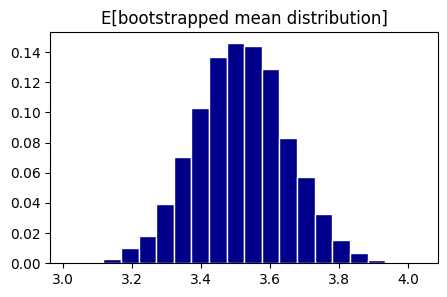

In [ ]:
n = 30
sample = RV('', dist('normal', 3.5, 1)).sample(n)

bootstrap = RV('bootstrapped mean distribution',
               dist('sampling', population=sample)).E(per_sim=n)
bootstrap.plot()

## Mixtures

For more complex mixtures there's static method `mix`,

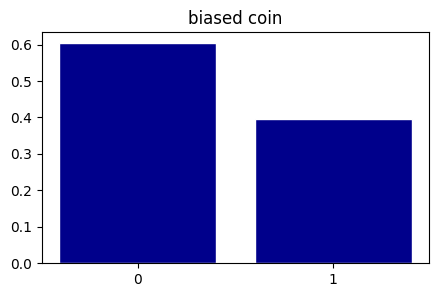

In [ ]:
Head = RV('Head', dist('δ', 0))
Tail = RV('Tail', dist('δ', 1))

Bent_coin = RV.mix('biased coin', [Head, Tail], [3, 2])
Bent_coin.plot(bar=True)

These are also random variables, so all the previous operators work on them:

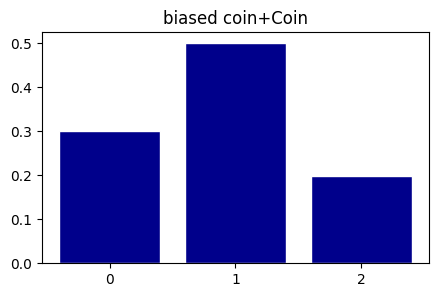

In [ ]:
(Bent_coin+Coin).plot(bar=True)

The next code models a urn where there are red, green and blue balls in a $3:2:1$ ratio,

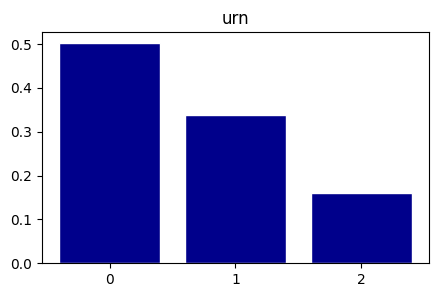

In [ ]:
balls_sampler = [RV(c, dist('δ', i)) for i,c in enumerate('RGB')]

Urn = RV.mix('urn', balls_sampler, [3, 2, 1])
Urn.plot(bar=True)

To perform cluster sampling, we can use `numpy` capabilities,

In [ ]:
# generate clusters of 12 balls
Urn.sample(120).reshape(10,12)

array([[1, 1, 1, 2, 1, 0, 0, 0, 1, 0, 0, 1],
       [1, 2, 2, 2, 0, 1, 0, 0, 0, 1, 1, 2],
       [0, 0, 0, 2, 0, 2, 1, 0, 1, 0, 0, 1],
       [1, 0, 1, 1, 1, 1, 0, 2, 1, 0, 2, 0],
       [2, 0, 2, 2, 0, 0, 1, 0, 1, 1, 1, 0],
       [1, 1, 0, 1, 2, 0, 1, 0, 1, 1, 0, 1],
       [1, 1, 0, 2, 1, 1, 2, 0, 1, 0, 1, 0],
       [0, 2, 0, 0, 0, 1, 0, 1, 1, 1, 0, 2],
       [0, 1, 1, 1, 0, 1, 2, 1, 0, 0, 0, 0],
       [0, 2, 1, 1, 0, 0, 2, 0, 2, 0, 0, 2]])

We can also do (a kind of) stratified sampling,

In [ ]:
# define some population of people's heigths
pop = RV('N', dist('normal', 165, 20)).sample(1000)

# make three groups
short  = pop[pop<=150]
medium = pop[(150<pop) & (pop<180)]
tall   = pop[pop>=180]

sampler = [RV(name, dist('sampling', group))
           for name,group in zip('SMT',[short,medium,tall])]

# each sample should have, on average, one short, three medium and two high people
stratified = RV.mix('stratified sampling', sampler, [1, 3, 2])
stratified.sample(30)

array([155.10090411, 153.49874205, 160.5918118 , 176.50909242,
       186.80322416, 178.37744584, 136.76302436, 199.23688995,
       185.51843148, 184.03975762, 176.50909242, 160.91850423,
       179.75063292, 164.67693827, 172.078721  , 183.78070207,
       169.91966229, 149.11812768, 113.5275842 , 200.35883501,
       185.5711661 , 157.28821777, 104.84106124, 145.49183734,
       195.23919204, 153.49874205, 170.17578978, 145.17189373,
       161.22932421, 159.2944742 ])

## Functions of Random Variables

Any expression including a random variable is also a random variable.

There's option `'apply'` in function `dist` that, given function $f$ and a sequence of random variables $X,Y,Z,\ldots$, returns random variable $f(X,Y,Z,\ldots)$.

Let's produce a new random variable that models a dice with faces 2 to 7, based on a standard dice:

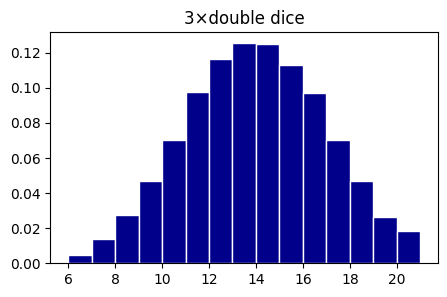

In [ ]:
dice6 = RV('d6', dist('sampling', population=[1,2,3,4,5,6]))

dice6_plus1 = RV('double dice', dist('apply', lambda roll: roll+1, dice6))

(3*dice6_plus1).plot(n=100_000, bins=15)

The next example defines a random variable that samples lines (i.e., each sampled value is a function representing one line), given distributions for the slope and intercept:

In [ ]:
intercept = RV(r'α', dist('normal', loc=0, scale=1))
slope     = RV(r'β', dist('normal', loc=0, scale=0.25))

line_sampler     = dist('apply', lambda α,β: (lambda x: α+β*x), intercept, slope)
linear_functions = RV('lines', line_sampler)

Let's sample some lines:

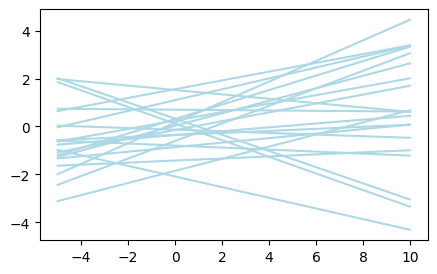

In [ ]:
fig, ax = plt.subplots(figsize=(5,3))
xs = np.linspace(-5, 10, 30)

for f in linear_functions.sample():
  ax.plot(xs, f(xs), color='lightblue')



---



## Solving Probabilistic and Statistical Problems

In [ ]:
n = 100_000  # sampling size

---

+ If a family has two children and one of them is a boy, what is the probability that the other will also be a boy?

In [ ]:
from fractions import Fraction

# note: possible to sample non-numeric values, but other RV methods won't work
C = RV('children', dist('sampling', population=['bb', 'bg', 'gb', 'gg']))
sample = C.sample(n)

at_least_one_boy = sum('b' in s for s in sample)
two_boys         = sum('bb' == sample)

Fraction(two_boys, at_least_one_boy).limit_denominator(100)

Fraction(1, 3)

---

+ From a poll of $100$ people, $55$ says they will vote for the first ranked party. What are the chances of that party winning the election with absolute majority?

In [ ]:
X = RV('Voters', dist('binomial', n=100, p=55/100))

prob = sum(X.sample(n) > 50) / n
print(f'prob(win | data) ≈ {prob:.3%}')

prob(win | data) ≈ 81.874%


---

+ Julie has an height of $1.62$ meters and will have a blind date with a man. What is the probability that he is taller than Julie given the male height distribution is $\mathcal{N}(1.8, 0.114)$?

In [ ]:
X = RV('N', dist('normal', loc=180, scale=11.4)) # convert to centimeters

prob = sum(X.sample(n) > 162) / n
print(f'prob(height > 162 | data) ≈ {prob:.3%}')

prob(height > 162 | data) ≈ 94.163%


---

+ Assume $\mathcal{N}(1.8, 0.114)$ and $\mathcal{N}(1.62, 0.101)$ for the male and female height distributions. What is the probability that a man is at least $12$ centimeters higher than a woman?

In [ ]:
M = RV('Male',   dist('normal', loc=180, scale=11.4))
F = RV('Female', dist('normal', loc=162, scale=10.1))

prob = sum(M.sample(n) > F.sample(n) + 12) / n
print(f'prob(higher | data) ≈ {prob:.3%}')

prob(higher | data) ≈ 65.356%


---

+ A manager expects a factory to break $40$ times per year. However, he will not take a profit if the number of breaks are higher or equal to $52$. What is the factory's probability for profit?

In [ ]:
B = RV('#breaks', dist('poisson', lam=40))

prob = sum(B.sample(n) < 52) / n
print(f'prob(profit | data) ≈ {prob:.3%}')

prob(profit | data) ≈ 96.214%


Let's try using the normal approximation of the Poisson,

In [ ]:
BN = RV('#breaks', dist('normal', 40, sqrt(40)))

prob = sum(BN.sample(n) < 52) / n
print(f'prob(profit | data) ≈ {prob:.3%}')

prob(profit | data) ≈ 97.108%


---

+ There's a population of balls where $25\%$ are red. Making a urn with $100$ balls, what is the probability that at least $40$ are red?

In [ ]:
B = RV('balls', dist('binomial', n=100, p=0.25))

prob = sum(B.sample(n) >= 40) / n
print(f'prob(#red balls ≥ 40 | data) ≈ {prob:.3%}')

prob(#red balls ≥ 40 | data) ≈ 0.070%


---

+ From a population with a known sd of $2.5$, a sample of size $20$ is taken with a mean sample of $7.9$. What is the $90\%$ confidence interval?

We can define the random variable of the standard error of the mean,

In [ ]:
X = RV('N', dist('normal', loc=7.9, scale=2.5)).E(per_sim=20)
X.summary(alpha=0.9)

Summary(mean=7.9, low=6.98, median=7.91, high=8.83, skew=-0.0299)

or restrict the sd's distribution given the sample size,

$$\sigma_{\overline{X}} = \frac{\sigma}{\sqrt{n}}$$

In [ ]:
X = RV(r'N', dist('normal', loc=7.9, scale=2.5/sqrt(20)))
X.summary(alpha=0.9, sig=4)

Summary(mean=7.904, low=6.952, median=7.912, high=8.835, skew=-0.02906)

---

+ An anesthetic was tried in nine pacients, that sleep a given number of hours. Produce a $95\%$ confidence interval of the population mean of slept hours.

In [ ]:
hours = [2.7, 2.8, 3.0, 2.3, 2.3, 2.2, 2.8, 2.1, 2.4]

X = RV('hours', dist('sampling', population=hours)).E(per_sim=len(hours))
X.summary()

Summary(mean=2.51, low=2.32, median=2.51, high=2.71, skew=0.0598)

---

+ From a sample of $100$ persons, their mean weight is $62.7$Kg with a variance of $25$. Provide a $95\%$ confidence interval for this sample.

In [ ]:
X = RV('N', dist('normal', 62.7, sqrt(25))).E(per_sim=100)
X.summary(sig=4)

Summary(mean=62.7, low=61.73, median=62.7, high=63.7, skew=0.03142)

---

+ In a sample of $50$ balls, $25\%$ are red. Compute the $99\%$ confidence intervals for the proportion of balls in the population.

In [ ]:
Red   = RV('Red',  dist('δ', 1))
Other = RV('~Red', dist('δ', 0))

size_sample = 50
Balls = RV.mix('balls', [Red, Other], [25, 75]).E(per_sim=size_sample)
Balls.summary(alpha=0.99)

Summary(mean=0.25, low=0.1, median=0.24, high=0.42, skew=0.168)

Another way to solve the problem is to use a binomial to sample the number of red balls, and then compute the proportions,

In [ ]:
X = RV('balls', dist('binomial', n=size_sample, p=0.25))

proportions = X.sample(n) / size_sample
np.quantile(proportions, [.005, .995])

array([0.1 , 0.42])

---
+ A baker claims that his bread height is more than $15$ cm, on average. Several of his customers do not believe him. To persuade his customers that he is right, the baker decides to do a hypothesis test. He bakes $10$ loaves of bread. The mean height of the sample loaves is $15.5$ cm. The baker knows from baking hundreds of loaves of bread that the standard deviation for the height is $0.5$ cm and the distribution of heights is normal. [ref](https://stats.libretexts.org/Bookshelves/Introductory_Statistics/Introductory_Statistics_(OpenStax)/09%3A_Hypothesis_Testing_with_One_Sample/9.05%3A_Rare_Events_the_Sample_Decision_and_Conclusion)

In [ ]:
X = RV('height', dist('normal', 15, 0.5)) # H0: mean ≤ 15

prob = sum(X.E(per_sim=10).sample(n) >= 15.5) / n
print(f'prob(data | mean ≤ 15) ≈ {prob:.3%}')

prob(data | mean ≤ 15) ≈ 0.086%


or,

In [ ]:
X = RV('height', dist('normal', 15, 0.5/sqrt(10)))

prob = sum(X.sample(n) >= 15.5) / n
print(f'prob(data | mean ≤ 15) ≈ {prob:.3%}')

prob(data | mean ≤ 15) ≈ 0.068%


There's strong evidence against the hypothesis of the bread mean height being less than $15$.

---

+ A company makes computer batteries and claims they last. on average, more than $3.5$ hours. A sample of $45$ batteries lasted an average of $3.72$ hours. Assume the standard deviation is $0.7$ hours [ref](https://www.amazon.com/dp/1592578659)

In [ ]:
X = RV('time', dist('normal', 3.5, 0.7)).E(per_sim=45) # H0: mean ≤ 3.5

prob = sum(X.sample(n) >= 3.72) / n
print(f'prob(data | mean ≤ 3.5) ≈ {prob:.3%}')

prob(data | mean ≤ 3.5) ≈ 1.746%


The sample provides good evidence in favor of the company's claim.

---

+ A random survey of $75$ death row inmates revealed that the mean length of time on death row is $17.4$ years with a standard deviation of $6.3$ years. Conduct a hypothesis test to determine if the population mean time on death row could likely be $15$ years. [ref](https://stats.libretexts.org/Bookshelves/Introductory_Statistics/Introductory_Statistics_(OpenStax)/09%3A_Hypothesis_Testing_with_One_Sample/9.05%3A_Rare_Events_the_Sample_Decision_and_Conclusion/9.5E%3A_Rare_Events_the_Sample_Decision_and_Conclusion_(Exercises))

Since the standard deviation of the population is unknown, our random variable models the sample mean,

In [ ]:
X = RV('Time on Death', dist('normal', 15, 6.3)).E(per_sim=75)

prob = sum(X.sample(n) >= 17.4) / n
print(f'prob(data | mean ≤ 15y) ≈ {prob:.3%}')

prob(data | mean ≤ 15y) ≈ 0.045%


The data is not compatible with the hypothesis that the mean length of time is, at most, $15$.

---

+ A phone company states that the average client bill is less the $100$ dollars. A random sample of $40$ reports an average bill of $101.25$ with a sample sd of $17.38$. [ref](https://www.amazon.com/dp/1592578659)

In [ ]:
X = RV('bills', dist('normal', 100, 17.38)).E(per_sim=40)

prob = sum(X.sample(n) >= 101.25) / n
print(f'prob(data | mean ≤ 100$) ≈ {prob:.3%}')

prob(data | mean ≤ 100$) ≈ 32.748%


The sample evidence is compatible with the company's statement.

---

+ We sampled $10$ balls and found their average weight is $0.5$ with sample variance of $0.09$. What is the confidence interval for the population average weight?


In [ ]:
n_balls, mu, sd = 10, 0.5, sqrt(0.09)

X = RV('weight', dist('normal', mu, sd)).E(per_sim=n_balls)
X.summary()

Summary(mean=0.5, low=0.318, median=0.499, high=0.687, skew=-0.00987)

But, given the small size of the sample, and the fact that we only know the sample variance (not the population variance), it's better to use a t-Student,

In [ ]:
X = RV('weight', dist('t', df=n_balls-1, loc=mu, scale=sd)).E(per_sim=n_balls)
X.summary()

Summary(mean=0.498, low=0.281, median=0.5, high=0.709, skew=-0.0299)

---

+ A company states that their medicine is $90\%$ effective. We tested $15$ patients and $11$ were cured. Should we accept the company's statement?

In [ ]:
θ, n_patients, n_cured = 0.9, 15, 11
B = RV('cured', dist('binomial', n_patients, θ))

prob = sum(B.sample(n) <= n_cured) / n
print(f'prob({n_cured} or less cured out of {n_patients} | θ={θ}) ≈ {prob:.2%}')

prob(11 or less cured out of 15 | θ=0.9) ≈ 5.51%


If the threshold is set to $0.05$, we would not reject the company's statement.

What if we tested again for $100$ patients, and $80$ were cured?

In [ ]:
θ, n_patients, n_cured = 0.9, 100, 80
B = RV('cured', dist('binomial', n_patients, θ))

prob = sum(B.sample(n) <= n_cured) / n
print(f'prob({n_cured} or less cured out of {n_patients} | θ={θ}) ≈ {prob:.3f}')

prob(80 or less cured out of 100 | θ=0.9) ≈ 0.002


With this larger sample, and still assuming the same threshold, we have enough information to reject the company's statement.

---

+ A faculty department had $393$ female applications with $95$ admissions, and $191$ male applications with $53$ admissions. Are these numbers compatible with the assumption that there is no gender bias?

In [ ]:
# population of admissions: 1 (admitted), 0 (rejected)
admissions = np.concatenate([np.repeat(1, 95+53), np.repeat(0, 393-95+191-53)])

Adm = RV('admissions', dist('sampling', admissions, False))

def diff_proportions(n, n_females=393, n_males=191):
  res = np.zeros(n)
  for i in range(n):
    sample = Adm.sample(len(admissions))
    females, males = sample[:n_females], sample[n_females:]
    res[i] = sum(females)/n_females - sum(males)/n_males
  return res

X = RV('difference of proportions', diff_proportions)

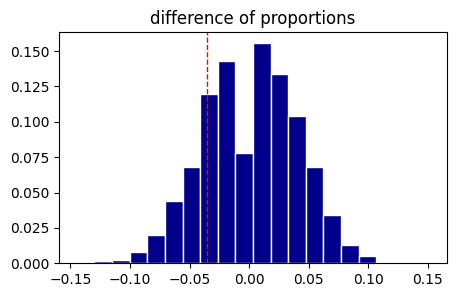

In [ ]:
observed_effect = 95/393 - 53/191
X.plot(observed_effect=observed_effect)

In [ ]:
# checking if males are favored
prob = sum(X.sample(n) < observed_effect) / n
print(f'prob(as extreme as observed effect | H0) ≈ {prob:.3f}')

prob(as extreme as observed effect | data) ≈ 0.145


The estimated probability for more extreme events is quite high, there's no solid evidence of gender bias.

---

+ Assume a normal population of car's gas mileage with standard deviation of $5.2$ miles/gallon. What is the minimum size of a sample needed to identify a $95\%$ confidence interval with a $2$ miles/gallon margin of error? [ref](https://www.amazon.com/dp/1592578659)

We define a function `target` that, given a sample size, outputs the confidence interval width. Then, we just iterate thru an interval of reasonable values to find our result.

In [ ]:
def target(sample_size):  # the mean is irrelevant for this problem
  X = RV('mileage', dist('normal', 0, 5.2)).E(per_sim=int(sample_size))
  summary = X.summary(n=100_000, alpha=0.95)
         # margin of error is half the interval width
  return significant(summary.high - summary.low) / 2

# the theoretical result is 25.969, so a size of 26 is needed (Kelly, pg.227)
{size:target(size) for size in range(20,32)}

{20: 2.285,
 21: 2.225,
 22: 2.175,
 23: 2.12,
 24: 2.095,
 25: 2.04,
 26: 2.0,
 27: 1.965,
 28: 1.925,
 29: 1.89,
 30: 1.855,
 31: 1.83}

> If the values to test are too many, it is possible to speed up with function `bisect.bisect_left` that performs a binary search.

---

+ A sample of size $10$ has mean $10.91$ and standard deviation $4.736$. What is its $95\%$ confidence interval?

Since nothing is said about the population distribution (it might not be normal) and given the small sample size (less than 30), this random variable will follow a t-Student:

In [ ]:
size = 10
X = RV('t', dist('t', df=size-1, loc=10.91, scale=4.736)).E(per_sim=size)
X.summary()

Summary(mean=10.9, low=7.5, median=10.9, high=14.2, skew=-0.0191)

### Example: Overestimating Profits

This quote is from Sam Savage's book _The Flaw of Averages_:

> To understand how pervasive the Flaw of Averages is, consider the
hypothetical case of a marketing manager who has just been asked
by his boss to forecast demand for a new - generation microchip.
>
>“That's difficult for a new product, ” responds the manager, “but I'm confident that annual demand will be between 50,000 and
150,000 units. ”
>
>“Give me a number to take to my production people, ” barks the boss.
“I can't tell them to build a production line with a capacity between
50,000 and 150,000 units! ”
>
> The phrase “ Give me a number ” is a dependable leading indicator
of an encounter with the Flaw of Averages, but the marketing
manager dutifully replies: “If you need a single number, I suggest
you use the average of 100,000.”
>
> The boss plugs the average demand, along with the cost of a
100,000 - unit capacity production line, into a spreadsheet model
of the business. The bottom line is a healthy \$10 million, which he
reports as the projected profit. Assuming that demand is the only
uncertainty and that 100,000 is the correct average (or expected)
demand, then \$10 million must be the average (or expected) profit.
Right?

Let's use a normal distribution with mean 100k and sd ~15k to simulate the manager estimate.

Expected Profit:  881700.0


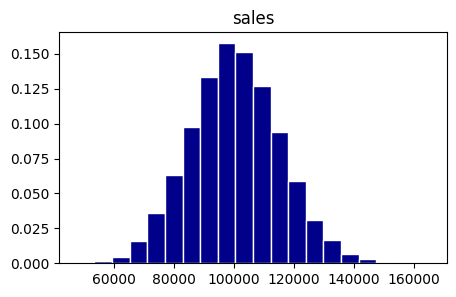

In [ ]:
rv_sales = RV('sales', dist('normal', 100_000, 15_000))
rv_sales.plot()

sales = rv_sales.sample(10_000)  # generate 10k sale simulations
sales = sales[sales <= 100_000]  # filter those larger than 100k

profit_per_sale = 10
expected_profit = significant(sales.mean() * profit_per_sale, 4)
print('Expected Profit: ', expected_profit)

Let's now use a truncated normal to perform the profit estimation:

Expected Profit:  881700.0


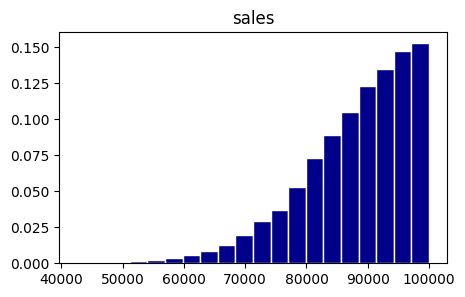

In [ ]:
rv_sales2 = RV('sales', dist('truncnorm', 100_000, 15_000, 0, 100_000))
rv_sales2.plot()

sales = rv_sales2.sample(10_000)  # generate 10k sale simulations

expected_profit = significant(sales.mean() * profit_per_sale, 4)
print('Expected Profit: ', expected_profit)

These two simulations produce similar estimates despite one using a censored distribution, and another using a truncated distribution.

The author explains:

> Wrong! The Flaw of Averages ensures that on average , profit will
be less than the profit associated with the average demand. Why? If
the actual demand is only 90,000, the boss won't make the projection
of $10 million. If demand is 80,000, the results will be even
worse. That's the downside. On the other hand, what if demand is
110,000 or 120,000? Then you exceed your capacity and can still
sell only 100,000 units. So profit is capped at \$10 million. There is
no upside to balance the downside [...] which helps explain why, on average, everything is below projection

### Example: The Birthday Paradox

> The birthday paradox, also known as the birthday problem, states that in a random group of 23 people, there is about a 50 percent chance that two people have the same birthday. Is this really true? [ref](https://www.scientificamerican.com/article/bring-science-home-probability-birthday-paradox/)

We sample from all possible birthdays (here, integers from 1 to 366 representing days),

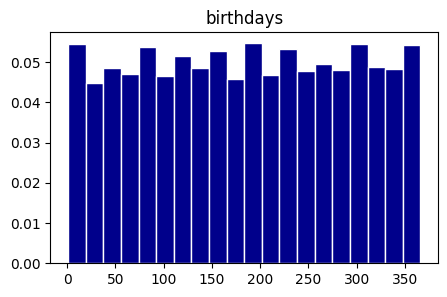

In [ ]:
birthdays = RV('birthdays', dist('sampling', population=np.arange(1,367)))
birthdays.plot()

We need to plug this random variable into a new sampler. This new sampler will generate, for each simulation, $n$ birthdays and verifies if there are two people with the same value.

In [ ]:
def shared_birthday_sampler(rv, n_persons):
  def sampler(n):
    """ True if repeated elements in sample of random variable, False otherwise """
    sample = rv.dist(n*n_persons).reshape(n, n_persons)
    return np.apply_along_axis(lambda row: len(np.unique(row))!=n_persons, 1, sample)
  return sampler

shared_birthday_sampler(birthdays, 15)(6)

array([ True, False, False, False, False,  True])

This sampler defines the distribution of a new random variable. We can simply generate lots of samples and compute its mean,

In [ ]:
shared_birthdays = RV('shared birthday', shared_birthday_sampler(birthdays, 23))
shared_birthdays.sample(10_000).mean()

0.5084

We can also check the distribution of the expected value for this rv:

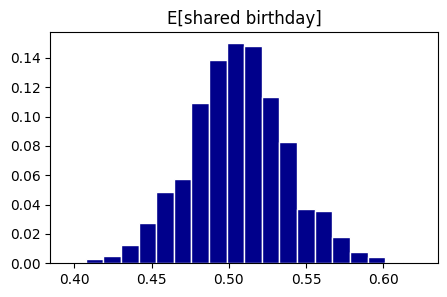

In [ ]:
shared_birthdays.E(per_sim=250).plot()

### Example: A Poisson Problem

> Manchester United scored 80 goals in 38 matches in the 1998-9 English Premier League season, an average of 2.1 goals per match. What is the probability of MU of scoring 3 goals in one match during that season? -- Michael Wood's _Making Sense of Statistics_

38 matches of 90 minutes means a total of 3420 minutes. Let's assume that all minutes during a match have a similar probability of getting goals and there's no two goals within a minute (we can always model seconds instead of minutes).

Our first rv is the sampling distribution of goals over the minutes of the Premier League. The sampling universe consists with 80 marked with a 1 for a goal (the 80 goals), or a zero for a non-goal (the remaining minutes).

In [ ]:
universe = np.concatenate((np.repeat(1,80), np.repeat(0,38*90-80)))

one_match = RV('one match', dist('sampling', population=universe, replace=False))
one_match.sample(90)

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0])

The next sampler simulates a match by sampling 90 minutes from the previous rv. Then sums all those values to compute the number of goals,

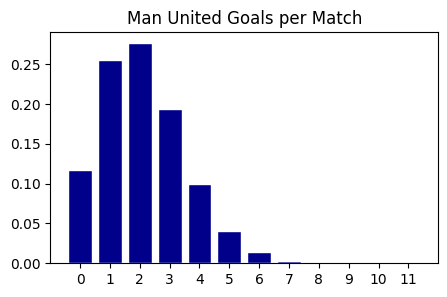

In [ ]:
def sum_goals(n):
  return np.array([np.sum(one_match.sample(90))
                   for _ in range(n)])

problem = RV('Man United Goals per Match', sum_goals)
problem.plot(n=100_000, bar=True)

To compute the probability:

In [ ]:
n_goals = 3
bin_goals = np.bincount(problem.sample(10_000))
print(f'prob({n_goals} goals | 1999 season) ≈ {bin_goals[n_goals] / sum(bin_goals):.2%}')

prob(3 goals | 1999 season) ≈ 20.51%


### Example: Confidence Interval

A questionnaire was made with options from 0 (bad) to 5 (good). A total of 98 valid answers were collected. What is the $95\%$ confidence interval for the mean response?

| answer  | frequency  |
|:-:|:-:|
| 0 |42 |
| 1 |21 |
| 2 |16 |
| 3 | 6 |
| 4 | 9 |
| 5 | 4 |

In [ ]:
responses = [(0,42),(1,21),(2,16),(3,6),(4,9),(5,4)]
responses = np.array([val for val,freq in responses for _ in range(freq) ])

First, we define a rv associated with the sampling distribution of responses,

In [ ]:
responses_rv = RV('Responses', dist('sampling', population=responses))
responses_rv.sample()

array([0, 0, 0, 4, 0, 0, 1, 0, 0, 5, 3, 0, 1, 1, 1, 2, 2, 5, 2, 0])

We will simulate polls of 98 answers using the previous rv,

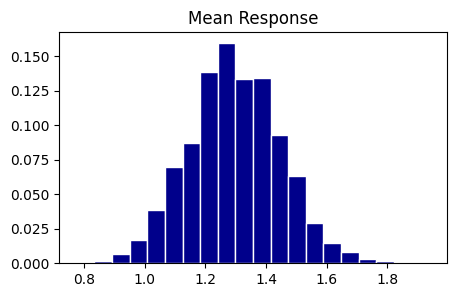

In [ ]:
def mean_response_sampler(n):
  polls = responses_rv.sample(n*len(responses)).reshape(n, len(responses))
  return np.mean(polls, axis=1) # compute mean for every row

mean_response_rv = RV('Mean Response', mean_response_sampler)
mean_response_rv.plot()

The 95% confidence interval is,

In [ ]:
results = mean_response_rv.sample(10_000)
np.quantile(results, [.025, .975])

array([1.01020408, 1.59183673])

### Example: Performing a t-test

Assume we wish to check if the measures from an experiment are significantly different from the control measures. One way to do this is applying a t-test that checks for the difference of the means.

In [ ]:
experiment = np.array([27,20,21,26,27,31,24,21,20,19,23,24,28,19,24,29,18,20,17,
                       31,20,25,28,21,27])
control    = np.array([21,22,15,12,21,16,19,15,22,24,19,23,13,22,20,24,18,20])

observed_mean_diff = np.mean(experiment) - np.mean(control)

To perform the t-test in this setting, we need a rv with a sampling distribution that permutes the initial data,

In [ ]:
allData = np.concatenate((experiment, control))

permute_rv = RV('perm', dist('sampling',
                             population = allData,
                             replace    = False))

The next random variable, `t_test_rv`, generates random samples of differences of means. After sampling the data, we use the first ones to create a fake experiment and the last ones to create a fake control, and then we compute the respective fake difference of means. This will be the task of the next rv, its distribution is over all possible difference of means given the initial data.

In [ ]:
def diff_means_statistic(sample):
  fake_experiment = sample[:len(experiment)]
  fake_group      = sample[len(experiment):]
  return np.mean(fake_experiment) - np.mean(fake_group)

def diff_means_sampler(n):
  return np.array([diff_means_statistic(permute_rv.sample(len(allData)))
                   for _ in range(n)])

t_test_rv = RV('Diff Means', diff_means_sampler)

Let's plot the results,

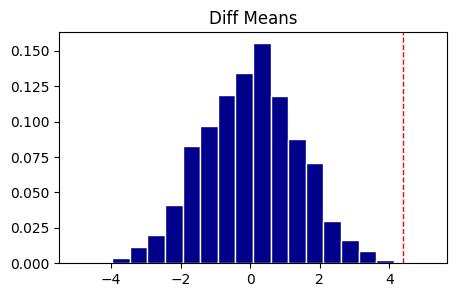

In [ ]:
t_test_rv.plot(observed_effect=observed_mean_diff)

We can compute a kind of p-value, but this one has a probability interpretation:

In [ ]:
n = 100_000
diffs = t_test_rv.sample(n)
prob = sum(abs(diffs) > observed_mean_diff) / n

print(f'prob(as extreme as observed | H0) ≈ {prob:.3%}')

prob(as extreme as observed | H0) ≈ 0.090%


This t-test implementation is an example of a permutation test, which is a resampling technique. Like the bootstrap, permutation tests can also be modelled using this sampling framework.

### Example: Doing the $\chi^2$-Test

+ Suppose you run a casino and you suspect that a customer has replaced a die provided by the casino with a ``crooked die''; that is, one that has been tampered with to make one of the faces more likely to come up than the others.  You apprehend the alleged cheater and confiscate the die, but now you have to prove that it is crooked.  You roll the die $60$ times and get the following results:

| Value  |  Frequency |
|:------:|:----------:|
|   1    |      8     |
|   2    |      9     |
|   3    |     19     |
|   4    |      6     |
|   5    |      8     |
|   6    |     10     |

What is the probability of seeing results like this by chance?

First, let's represent the facts,

In [ ]:
n_throws = 60

experiment = [(1,8),(2,9),(3,19),(4,6),(5,8),(6,10)]
experiment = np.array([val for val,freq in experiment for _ in range(freq) ])

The standard test statistic here is the $\chi^2$:

> The chi-squared test is used to determine whether there is a significant difference between the expected frequencies and the observed frequencies in one or more categories -- [wikipedia](https://en.wikipedia.org/wiki/Chi-squared_test)

The next function computes this statistic:

In [ ]:
def chiSquare(sample, expected):
                             # add one of each to prevent zero counts
  sample = np.append(sample, np.arange(1, len(expected)+1))
  sampleCount = np.bincount(sample) - 1 # bincount done, remove one of each
  return np.sum((sampleCount[1:]-expected)**2/expected)

First we define a random variable for a fair dice, then use it to create a sampler that throws the dice $60$ times and returns its $\chi^2$ statistic,

In [ ]:
expected = np.repeat(1,6)  # the expected proportions for a fair die
observed_effect = chiSquare(experiment, expected)

dice = RV('dice', dist('sampling', population=[1,2,3,4,5,6], replace=True))

def sampler(n):
  return np.array([chiSquare(dice.sample(n_throws), expected) for _ in range(n)])

χ2 = RV('χ2 test', sampler)

Let's plot the distribution and compare with the observed effect:

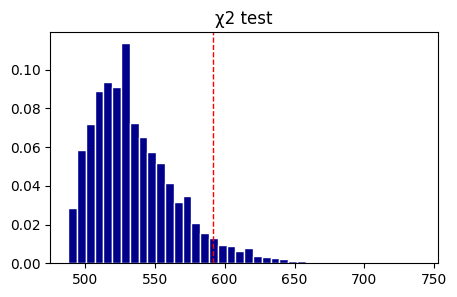

In [ ]:
χ2.plot(bins=40, observed_effect=observed_effect)

To find its 'p-value',

In [ ]:
n = 100_000
prob = sum(χ2.sample(n) > observed_effect) / n

print(f'prob(as extreme as observed | H0) ≈ {prob:.3%}')

prob(as extreme as observed | H0) ≈ 5.457%


The casino has another problem: a slot machine is giving unexpected rewards and we need to know if these results are a symptom of something not working.

| Value  |  Expected  | Real |
|:------:|:----------:|:-----:
|  -2    |    977     |  965 |
|  20    |      8     |   10 |
|  40    |      8     |    9 |
|  80    |      6     |    9 |
| 200    |      1     |    7 |

What is the probability of seeing results like this by chance?

In [ ]:
expected = np.array([977,8,8,6,1])

real = [(1,965),(2,10),(3,9),(4,9),(5,7)]
real = np.array([val for val,freq in real for _ in range(freq) ])

observed_effect = chiSquare(real, expected)

n_sampler = [RV(str(i), dist('δ', i)) for i in [1,2,3,4,5]]
Urn = RV.mix('urn', n_sampler, expected)

def sampler(n):
  return np.array([chiSquare(Urn.sample(1000), expected) for _ in range(n)])

χ2 = RV('χ2 test', sampler)

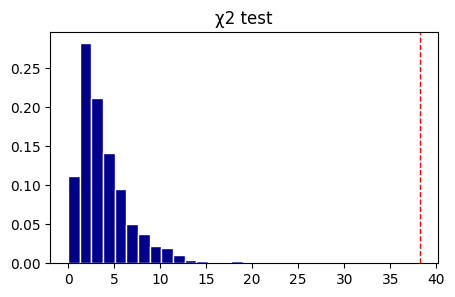

In [ ]:
χ2.plot(n=2000, observed_effect=observed_effect)

In [ ]:
n = 3_000
prob = sum(χ2.sample(n) > observed_effect) / n

print(f'prob(as extreme as observed | H0) ≈ {prob:.3%}')

prob(as extreme as observed | H0) ≈ 0.000%


### Example: Model Comparison

Consider we have two urns with red and blue balls. One urn has $50\%$ red balls, the other has $80\%$ red balls.

One urn was select in secret, and $10$ balls were sampled. The sample consists of $9$ red balls and $1$ blue ball.

In [ ]:
n_reds, n_blues = 9, 1

n = n_reds + n_blues

prop_red = n_reds / n # proportion of reds

Given this data, what are the odds of initially selecting each urn?

We can start by creating two random variables that model each urn. These random variables will output the proportion of red balls for each sample of size $10$,

In [ ]:
R = RV('Red',  dist('δ', 1))
B = RV('Blue', dist('δ', 0))

model1 = RV('M1', RV.mix('RB', [R, B], [5, 5])).E(per_sim=n)
model2 = RV('M2', RV.mix('RB', [R, B], [8, 2])).E(per_sim=n)

Now we need to sample from both random variables, and count how many times the observed proportion of red balls is found on both samples:

In [ ]:
from fractions import Fraction

samples_M1 = model1.sample(100_000)
samples_M2 = model2.sample(100_000)

odds = Fraction(sum(samples_M1 == prop_red),
                sum(samples_M2 == prop_red)).limit_denominator(100)
odds

Fraction(3, 80)

The analytical answer gives odds of $1:27$.

We could easily expand this setup to compare three or more models.

Another generalization concerns prior information. In the previous example, the prior odds were $1:1$ (selecting from each urn had the same initial probability). But if they were, say, $4:1$, we would simply multiply the prior odds with the simulation odds, to produce the posterior odds:

In [ ]:
prior_odds = Fraction(4,3)

posterior_odds = prior_odds * odds
posterior_odds

Fraction(8, 165)

### Example: If Bayes didn't exist :-)

> Consider a problem in estimating the soundness of a used car one considers purchasing (after Wonnacott and Wonnacott, 1990, p. 93). Seventy percent of the cars are known to be OK on average, and 30 percent are faulty. Of the cars that are really OK, a mechanic correctly identifies 80 percent as “OK” but says that 20 percent are “faulty”; of those that are faulty, the mechanic correctly identifies 90 percent as faulty and says (incorrectly) that 10 percent are OK.
We wish to know the probability that if the mechanic says a car is “OK,” it really is faulty - Simon, _Resampling, The New Statistics_, p.408

Let's save these probabilities in some variables:

In [ ]:
p_ok, p_nok = 0.7, 0.3

p_yes_ok,  p_no_ok  = 0.8, 0.2  # conditional probabilities
p_yes_nok, p_no_nok = 0.1, 0.9

This is typical Bayes:

$$p(\text{¬ok} | \text{+}) = \frac{p(\text{¬ok}) p(\text{+|¬ok})}{p(\text{¬ok})p(\text{+|¬ok}) + p(\text{ok})p(\text{+|ok})}$$

In Python,

In [ ]:
p_nok_yes = (p_nok*p_yes_nok) / ((p_nok*p_yes_nok)+(p_ok*p_yes_ok))
print(f'prob(¬ok | +) ≈ {p_nok_yes:.3%}')

prob(¬ok | +) ≈ 5.085%


But forgetting Bayes for a moment, how could we sample this problem?

Let's define four types of balls, one for each joint probability:

1. $p(\text{ok}, \text{+}) = p(\text{+} | \text{ok})p(\text{ok}) = 0.56$
1. $p(\text{ok}, \text{–}) = 0.14$
1. $p(¬\text{ok}, \text{+}) = 0.03$
1. $p(¬\text{ok}, \text{–}) = 0.27$

And define a urn with $100$ balls following these proportions:

In [ ]:
balls = [(1,56), (2,14), (3,3), (4,27)]
balls = np.array([val for val,freq in balls for _ in range(freq) ])

Urn = RV('urn', dist('sampling', balls, True))

The answer is to sample many balls from the urn, and compare the ratio of how many $3$ balls (the faulty cars that the mechanic said were ok) by the number of $1$ and $3$ balls (all the cars the mechanic said were ok):

In [ ]:
sample = Urn.sample(100_000)

p_nok_yes = sum(sample==3) / sum((sample==1) | (sample==3))
print(f'prob(¬ok | +) ≈ {p_nok_yes:.3%}')

prob(¬ok | +) ≈ 5.133%


### Example: Correlation

The next datasets define the Anscombe quartet, data designed to have the same values for the mean, variance and correlation,

<center><img src='https://raw.githubusercontent.com/jpneto/Prog.I/master/imgs/anscombe_quartet.jpg' width=450px></center>

These are the values:

In [ ]:
data1 = np.array([[10, 8, 13, 9, 11, 14, 6, 4, 12, 7, 5],
                  [8.04, 6.95, 7.58, 8.81, 8.33, 9.96, 7.24, 4.26, 10.84, 4.82, 5.68]])

data2 = np.array([[10, 8, 13, 9, 11, 14, 6, 4, 12, 7, 5],
                  [9.14, 8.14, 8.74, 8.77, 9.26, 8.10, 6.13, 3.10, 9.13, 7.26, 4.74]])

data3 = np.array([[10, 8, 13, 9, 11, 14, 6, 4, 12, 7, 5],
                  [7.46, 6.77, 12.74, 7.11, 7.81, 8.84, 6.08, 5.39, 8.15, 6.42, 5.73]])

data4 = np.array([[8, 8, 8, 8, 8, 8, 8, 19, 8, 8, 8],
                  [6.58, 5.76, 7.71, 8.84, 8.47, 7.04, 5.25, 12.50, 5.56, 7.91, 6.89]])

Let's confirm that the Pearson's correlation is basically the same:

In [ ]:
from scipy.stats import pearsonr

print(pearsonr(data1[0], data1[1]).statistic)
print(pearsonr(data2[0], data2[1]).statistic)
print(pearsonr(data3[0], data3[1]).statistic)
print(pearsonr(data4[0], data4[1]).statistic)

0.81642051634484
0.8162365060002427
0.8162867394895982
0.8165214368885029


One way to find correlation by sampling is to compare data by rank. The more matched the ranks of two sequences are, the higher the sum of their rank products.

The next code fixes one sequence and permutes the other, finding the sum of the products of their ranks. This is the task of `corr_sampler`,

In [ ]:
data = data1 # select one: from data1 to data4

permute_rv = RV('perm', dist('sampling', population=data[1], replace=False))

def sum_rank_product(xs, ys):
  """ sum the product of ranks """
  return np.sum((xs.argsort().argsort()) *
                (ys.argsort().argsort()))

def corr_sampler(n):
  return np.array([sum_rank_product(data[0], permute_rv.sample(len(data[1])))
                   for _ in range(n)])

corr_rv = RV('corr', corr_sampler)

Let's compute the sampling correlation one of the datasets:

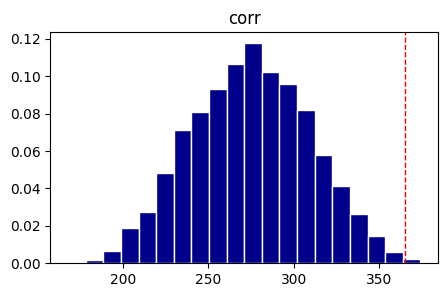

In [ ]:
observed_effect = sum_rank_product(data[0], data[1])

corr_rv.plot(observed_effect=observed_effect)

The correlation value is the proportion of those sums as extreme as the observed effect. A strong evidence of positive correlation will be near $0$, a strong evidence of negative correlation will be near $1$, and no evidence of correlation will be near $0.5$.

In [ ]:
n = 100_000
prob = sum(corr_rv.sample(n) > observed_effect) / n
print(f'corr(data) ≈ {prob:.3}')

corr(data) ≈ 0.0014


The results for each dataset were:

+ dataset 1: 0.1%

+ dataset 2: 1%

+ dataset 3: 0%

+ dataset 4: 27%

i.e., different correlation values for all four datasets of the Anscombe quarter.

+ One problem where the method does not work ([ref](https://twitter.com/ProbFact/status/1669743499556663302)):

Let $U$ and $V$ be independent random variables representing the roles of two identical dice.

Let $X = U + V$ and $Y = U - V$.

Then $X$ and $Y$ have zero correlation. But $X$ and $Y$ have the same parity, so they're not independent.

In [ ]:
U = RV('d1', dist('sampling', np.arange(1,7)))
V = RV('d2', dist('sampling', np.arange(1,7)))

m = 10_000
Us, Vs = U.sample(m), V.sample(m)

Xs = Us + Vs # X and Y share the same dice results
Ys = Us - Vs

Let's check Pearson's correlation to confirm that $X$ and $Y$ have zero correlation,

In [ ]:
print(pearsonr(Xs, Ys).statistic)

-0.002852174217240472


Let's try the sampling algorithm,

In [ ]:
permute_Ys = RV('perm', dist('sampling', population=Ys, replace=False))

def corr_sampler(n):
  return np.array([sum_rank_product(Xs, permute_Ys.sample(m))
                   for _ in range(n)])

corr_rv = RV('corr', corr_sampler)

n = 5_000
observed_effect = sum_rank_product(Xs, Ys)
prob = sum(corr_rv.sample(n) > observed_effect) / n
print(f'corr(data) ≈ {prob:.3}')

corr(data) ≈ 0.724


If we change the size of the sampling the correlation data differs wildly. This is probably because the ranking of just six different values does not allow for enough variation in the sampling. We could try to replace the rank with another measure, like the parity if that was prior information.



---

### Example: Doing an ANOVA

A satisfaction survey on three shops was made on a scale 1 to 10:

In [ ]:
shop1 = [7,7,6,5,3]
shop2 = [8,9,7,6,9]
shop3 = [9,7,8,10,8]

alldata = np.concatenate((shop1, shop2, shop3))

We wish to know if there is a difference on customer satisfaction over the three shops.  [ref](https://www.amazon.com/dp/1592578659)

Since all shops have the same number of answers our statistic will be the difference between the largest score and the smallest score (we could do averages, otherwise). The next function receives all data, splits it into the given number of shops/groups and computes the score difference.

In [ ]:
def range_sums(sample, n_groups):
  sums = np.array([sum(group) for group in np.split(sample, n_groups)])
  return np.max(sums) - np.min(sums)

observed_effect = range_sums(alldata, 3)

We define a random variable $X$ with the sampling distribution of all data, and use it to build a sampler. This sampler defines a distribution over score differences:

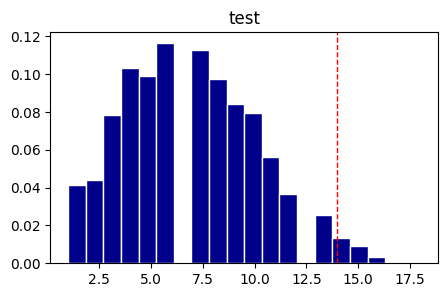

In [ ]:
X = RV('groups', dist('sampling', alldata, False))

Y = RV('test', lambda n: np.array([range_sums(X.sample(len(alldata)), 3)
                                   for _ in range(n)]))
Y.plot(observed_effect=observed_effect)

Computing the probability,

In [ ]:
prob = sum(Y.sample(n) >= observed_effect) / n
print(f'prob(as extreme as observed | H0) ≈ {prob:.3%}')

prob(as extreme as observed | data) ≈ 2.656%


tells us there is some evidence that costumer satisfaction is not the same on all shops.

### Example: Non-parametric Sign Test

We have a series of prices without known distribution. There's a claim the median price is below $180$. Is there evidence for the claim?

In [ ]:
prices = np.array([186,144,165,180,174,177,170,191,159,165,180,172,149,155,187,173,168,175])

Let's test if the median is $180$ or higher (the alternate hypothesis).


In [ ]:
median = 180

We will transform prices into signs, ie, prices higher than the median value $1$, and prices below value $-1$. Then, if summing the signs of a sample has expected value of zero, about half will be $1s$ and half will be zeros. Let's make a sampling distribution to model the generation of $\{-1,1\}$ and one that samples sums of signs:

In [ ]:
S = RV('price signs', dist('sampling', [-1,1]))

def sampler(n):
  return np.array([np.sum(S.sample(len(prices))) for _ in range(n)])

X = RV('test', sampler)

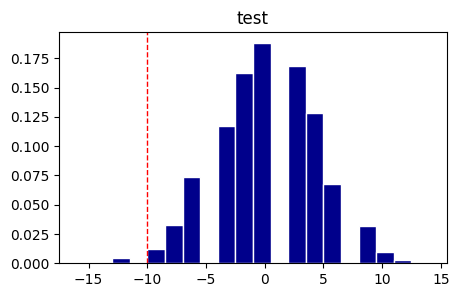

In [ ]:
observed_effect = np.sum(np.sign(prices - median))
X.plot(observed_effect=observed_effect)

Computing the probability,

In [ ]:
prob = sum(X.sample(n) <= observed_effect) / n
print(f'prob(as extreme as observed | median ≥ 180) ≈ {prob:.3%}')

prob(as extreme as observed | median ≥ 180) ≈ 94.941%


There's strong evidence to support the claim that the median is less than $180$.

### Example: Non-parametric Pair-Sample Sign Test

A test was made to check if a given program improves the costumer rating. For each costumer was registered the rating before and after the program.

In [ ]:
ratings = np.array([[7.9, 8.0, 6.5, 7.1, 7.9, 8.4, 7.7, 8.0, 8.2, 9.0],  # before
                    [8.2, 8.3, 7.0, 7.1, 7.7, 8.6, 7.8, 8.5, 8.4, 8.7]]) # after

n_ratings = len(ratings[0])

The company claims the program is successful. Is it?

The pairings cannot be broken (they refer to the same costumer), but we can swap them and sample the sum of differences. If there is some effect, the sum of differences of the real ratings should stand out.

In [ ]:
S = RV('swaps', dist('sampling', [-1,1]))

def diff_ratings(swaps):
  return np.sum((ratings[1] - ratings[0]) * swaps)

def sampler(n):
  return np.array([diff_ratings(S.sample(n_ratings)) for _ in range(n)])

X = RV('Paired-Sample', sampler)

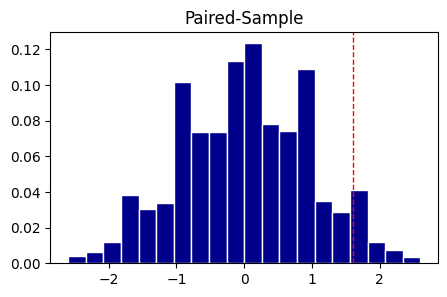

In [ ]:
observed_effect = np.sum((ratings[1] - ratings[0]))
X.plot(observed_effect=observed_effect)

In [ ]:
prob = sum(X.sample(n) >= observed_effect) / n
print(f'prob(as extreme as observed | H0) ≈ {prob:.3%}')

prob(as extreme as observed | H0) ≈ 5.721%


There is weak evidence for the claim. If the threshold was the tradicional $0.05$, the claim would be rejected.



---

<!--

Array Programming https://colab.research.google.com/drive/1dlc2dQ8Uem56vK4DkwHqG7EPgGwIsKeE?authuser=1#scrollTo=IVnMbQmHSvPI

Resampling https://colab.research.google.com/github/jpneto/topicsInPython/blob/main/notebooks/Resampling.ipynb

JAX https://colab.research.google.com/github/jpneto/topicsInPython/blob/main/notebooks/JAX.ipynb#scrollTo=1lqk4YRssAZy

-->